#### Name: Rajnita Leichombam
#### USC-ID : 1370432160
#### Github-Username: Rajnita

# 1. TextClassification

## 1-a 
The data is put under ../data/pos and ../data/neg folders

In [20]:
import tensorflow

from tensorflow import keras
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import re 
from collections import Counter
from collections import OrderedDict
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense , Flatten ,Embedding,Input, LSTM, Dense, Dropout, Conv1D, MaxPooling1D

## 1-b Data Exploration and Preprocessing

### 1-b-i  Reading the data, binary encoding for the sentiments

https://stackoverflow.com/questions/4813061/non-alphanumeric-list-order-from-os-listdir <br>
https://blog.codinghorror.com/sorting-for-humans-natural-sort-order/

In [21]:
pos_path = '../data/pos';
neg_path='../data/neg';

pos_files = os.listdir(pos_path)
neg_files=os.listdir(neg_path)

def sorted_alphanumeric(files_dir): 
    convert = lambda text: int(text) if text.isdigit() else text 
    alp_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(files_dir, key = alp_key)

pos_list=[]

for file in sorted_alphanumeric(pos_files):
    row={}
    path=pos_path+'/'+file
    row['filename']=file
    with open(path) as f:
        contents = f.read()
        row['contents']=contents 
    row['class']=1

    pos_list.append(row)
    

neg_list=[]
for file in sorted_alphanumeric(neg_files):
    row={}
    path=neg_path+'/'+file
    row['filename']=file
    with open(path) as f:
        contents = f.read()
        row['contents']=contents 
    row['class']=-1
    neg_list.append(row)
merged_list=pos_list+neg_list
raw_df=pd.DataFrame(merged_list);
raw_df


filename                                           contents  \
0     cv000_29590.txt  films adapted from comic books have had plenty...   
1     cv001_18431.txt  every now and then a movie comes along from a ...   
2     cv002_15918.txt  you've got mail works alot better than it dese...   
3     cv003_11664.txt   " jaws " is a rare film that grabs your atten...   
4     cv004_11636.txt  moviemaking is a lot like being the general ma...   
...               ...                                                ...   
1995  cv995_23113.txt  if anything , " stigmata " should be taken as ...   
1996  cv996_12447.txt  john boorman's " zardoz " is a goofy cinematic...   
1997   cv997_5152.txt  the kids in the hall are an acquired taste . \...   
1998  cv998_15691.txt  there was a time when john carpenter was a gre...   
1999  cv999_14636.txt  two party guys bob their heads to haddaway's d...   

      class  
0         1  
1         1  
2         1  
3         1  
4         1  
...     ...  
1995     -1  
1996     -1  
1997     -1  
1998     -1  
1999     -1  

[2000 rows x 3 columns]

## 1-b-ii Removing punctuation and numbers from data

#### REFERENCES

https://medium.com/analytics-vidhya/twitter-sentiment-analysis-134553698978 <br>
https://www.geeksforgeeks.org/python-remove-punctuation-from-string/ <br>
https://codefather.tech/blog/check-if-python-string-contains-number/ <br>

https://machinelearningmastery.com/clean-text-machine-learning-python/

In [22]:
def remove_punctuations(text):
## In this case 'awes\*ome' is replaced with 'awesome'
    pattern=r'[^\w\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_punctuations_replace_with_space(text):
    ## In this case 'awe\*some' is replaced with 'awe some'
    pattern=r'[^\w\s]'
    text = re.sub(pattern, ' ', text)
    return text

def remove_digits(text):
    pattern=r'[0-9]'
#     text=re.sub('\d', '', text)
    text = re.sub(pattern, '', text)
    return text

def remove_digits_replace_with_space(text):
    pattern=r'[0-9]'
#     text=re.sub('\d', '', text)
    text = re.sub(pattern, ' ', text)
    return text

def remove_unnecessary_spaces(text):
    return ' '.join(text.split())

def remove_underscore_replace_with_space(text):
    pattern=r'[_]'
    text=re.sub(pattern,' ',text)
    return text
def remove_underscore(text):
    pattern=r'[_]'
    text=re.sub(pattern,'',text)
    return text


### PLease ignore the following 12 lines. Only for my own observations

# text='asa dfdf \' EEE_sss3%%%# $ && ** ! ~~ :\'\' cucu*cu3232mber awe34some 4th 11wwew23 hdhj12 1212 12jjjj 1221 12-hour 4th $10 35-years-old 90\'s \'09 -1'
# text=remove_punctuations_replace_with_space(text)
# text=remove_digits_replace_with_space(text)
# text=remove_underscore_replace_with_space(text)
# text=remove_unnecessary_spaces(text)
# print(text)
# text='asa dfdf \' EEE_sss3%%%# $ && ** ! ~~ :\'\' cucu*cu3232mber awe34some 4th 11wwew23 hdhj12 1212 12jjjj 1221 12-hour 4th $10 35-years-old 90\'s \'09 -1'

# text=remove_punctuations(text)
# text=remove_digits(text)
# text=remove_underscore(text)
# text=remove_unnecessary_spaces(text)
# print(text)

### SAMPLE OUTPUT OF ABOVE CODE
# asa dfdf EEE cucu cu mber awe some th wwew hdhj jjjj hour th years old s
# asa dfdf EEE cucucumber awesome th wwew hdhj jjjj hour th yearsold s


#### NOTE

Here I am choosing to replace with a space whenever there is punctuation/numbers in a word. For example, word like 'life**^&&&beautiful' would be transformed to 'life beautiful' instead of 'lifebeautiful'.
While we could also, do transform 'awe12some' to either 'awesome' or 'awe some', i have chosen to have it as 'awe some' with a space

In [23]:
contents_list=raw_df['contents']
updated_content=[]

for text in contents_list:
    text=remove_punctuations_replace_with_space(text)
    text=remove_digits_replace_with_space(text)
    text=remove_underscore_replace_with_space(text)
    text=remove_unnecessary_spaces(text)
    updated_content.append(text)
    
raw_df_updated=raw_df.copy();
raw_df_updated['contents']=updated_content

#### OBSERVATIONS

If I convert '35-years-old' to 'yearsold' without space (just removing numbers and punctuations) , I am getting the count of unique words as 46787. Based on my study of the data, I chose to put space when I removed the punctuations and numbers and got number of unique words as 38911. This means, '35-years-old' becomes 'years old'

In [24]:
# contents_list=raw_df['contents']
# updated_content=[]

# for text in contents_list:
#     text=remove_punctuations(text)
#     text=remove_digits(text)
#     text=remove_underscore(text)
#     text=remove_unnecessary_spaces(text)
#     updated_content.append(text)
    
# raw_df_updated=raw_df.copy();
# raw_df_updated['contents']=updated_content

In [25]:
raw_df_updated

filename                                           contents  \
0     cv000_29590.txt  films adapted from comic books have had plenty...   
1     cv001_18431.txt  every now and then a movie comes along from a ...   
2     cv002_15918.txt  you ve got mail works alot better than it dese...   
3     cv003_11664.txt  jaws is a rare film that grabs your attention ...   
4     cv004_11636.txt  moviemaking is a lot like being the general ma...   
...               ...                                                ...   
1995  cv995_23113.txt  if anything stigmata should be taken as a warn...   
1996  cv996_12447.txt  john boorman s zardoz is a goofy cinematic deb...   
1997   cv997_5152.txt  the kids in the hall are an acquired taste it ...   
1998  cv998_15691.txt  there was a time when john carpenter was a gre...   
1999  cv999_14636.txt  two party guys bob their heads to haddaway s d...   

      class  
0         1  
1         1  
2         1  
3         1  
4         1  
...     ...  
1995     -1  
1996     -1  
1997     -1  
1998     -1  
1999     -1  

[2000 rows x 3 columns]

## 1-b-iii. Splitting into train and test data 

In [26]:
## raw_df_updated contains data in order i.e.000, 001 and so on.
##According to how the dataframe was constructed, 
##First 1000 rows belongs to positive sentiments and last 1000 to negative sentiments
## Hence splitting as below
pos_df=pd.DataFrame(raw_df_updated[0:1000])
neg_df=pd.DataFrame(raw_df_updated[1000:])

train_pos=pos_df[0:700]
test_pos=pos_df[700:]
train_neg=neg_df[0:700]
test_neg=neg_df[700:]

In [27]:
train_data=pd.concat([train_pos, train_neg], ignore_index=True)
print("\n******************************** TRAIN DATA******************************** ")
train_data


******************************** TRAIN DATA******************************** 


filename                                           contents  \
0     cv000_29590.txt  films adapted from comic books have had plenty...   
1     cv001_18431.txt  every now and then a movie comes along from a ...   
2     cv002_15918.txt  you ve got mail works alot better than it dese...   
3     cv003_11664.txt  jaws is a rare film that grabs your attention ...   
4     cv004_11636.txt  moviemaking is a lot like being the general ma...   
...               ...                                                ...   
1395  cv695_22268.txt  house on haunted hill starring taye diggs geof...   
1396  cv696_29619.txt  fit for a ghoul s night out fat girl stands ca...   
1397  cv697_12106.txt  marie couldn t talk paulie the parrot star of ...   
1398  cv698_16930.txt  well here s a distasteful thoroughly amateuris...   
1399   cv699_7773.txt  okay i just don t know why but i seem to be ge...   

      class  
0         1  
1         1  
2         1  
3         1  
4         1  
...     ...  
1395     -1  
1396     -1  
1397     -1  
1398     -1  
1399     -1  

[1400 rows x 3 columns]

In [28]:
test_data=pd.concat([test_pos, test_neg], ignore_index=True)
print("\n******************************** TEST DATA******************************** ")
test_data


******************************** TEST DATA******************************** 


filename                                           contents  class
0    cv700_21947.txt  let me start off by saying that leading up to ...      1
1    cv701_14252.txt  seen september at p m at the sony nickelodeon ...      1
2    cv702_11500.txt  the characters in palmetto collectively sweat ...      1
3    cv703_16143.txt  you ve got mail is the very definition of a cu...      1
4    cv704_15969.txt  with the sudden liberal emergence of personal ...      1
..               ...                                                ...    ...
595  cv995_23113.txt  if anything stigmata should be taken as a warn...     -1
596  cv996_12447.txt  john boorman s zardoz is a goofy cinematic deb...     -1
597   cv997_5152.txt  the kids in the hall are an acquired taste it ...     -1
598  cv998_15691.txt  there was a time when john carpenter was a gre...     -1
599  cv999_14636.txt  two party guys bob their heads to haddaway s d...     -1

[600 rows x 3 columns]

### 1-b-iv Counting the number of unique words and printing the list of unique words

https://pythonguides.com/python-count-words-in-file/

In [29]:
contents = raw_df_updated['contents']
splitted_words_all=[]
for data in contents:
    splitted_words_all.append(data.split());

frequencyMap = Counter(x for sublist in splitted_words_all for x in sublist)
sortedFrequencyMap=sorted(frequencyMap.items(), key=lambda item: item[1], reverse=True)
print("*********************SORTED FREQUENCY MAP BASED ON FREQUENCY*********************")
map_df=pd.DataFrame(sortedFrequencyMap, columns=["unique_word","frequency"])
map_df.shape
print(map_df)

*********************SORTED FREQUENCY MAP BASED ON FREQUENCY*********************
       unique_word  frequency
0              the      76574
1                a      38111
2              and      35581
3               of      34126
4               to      31939
...            ...        ...
38906      butabis          1
38907  fortenberry          1
38908        obeys          1
38909         rift          1
38910      stonily          1

[38911 rows x 2 columns]


In [30]:
print("\n*********************COUNT OF UNIQUE WORDS*********************")
print("The number of unique words is:", map_df['unique_word'].shape[0])


*********************COUNT OF UNIQUE WORDS*********************
The number of unique words is: 38911


In [31]:
print("\n*********************LIST OF UNIQUE WORDS*********************")
with pd.option_context('display.max_rows', None,):
    print(map_df['unique_word'])


*********************LIST OF UNIQUE WORDS*********************
0                              the
1                                a
2                              and
3                               of
4                               to
5                               is
6                               in
7                                s
8                               it
9                             that
10                              as
11                            with
12                             for
13                             his
14                            this
15                            film
16                               i
17                              he
18                             but
19                              on
20                             are
21                               t
22                              by
23                              be
24                             one
25                           movie
26                        

### 1-b-v Calculating average review length and std of review lengths

In [32]:
def get_review_lengths(contents_list):
    lengths=[]
    for content in contents_list:
        words=content.split()
        lengths.append(len(words))
    return lengths

In [33]:
review_df=raw_df_updated.copy()
all_data_contents_list=review_df['contents']
review_lengths = get_review_lengths(all_data_contents_list)
review_df['review_length']=review_lengths
print("**************************WHOLE DATA SET**************************")
print("WHOLE DATASET: Average review length of review lengths of documents is: ", np.mean(review_lengths))
print("WHOLE DATASET: Standard deviation of review lengths of documents is:", np.std(review_lengths))

tr_review_df=train_data.copy()
tr_data_contents_list=tr_review_df['contents']
tr_review_lengths = get_review_lengths(tr_data_contents_list)
tr_review_df['review_length']=tr_review_lengths

print("**************************TRAIN DATA SET**************************")
print("TRAIN DATASET: Average review length of review lengths of documents is: ", np.mean(tr_review_lengths))
print("TRAIN DATASET: Standard deviation of review lengths of documents is:", np.std(tr_review_lengths))

**************************WHOLE DATA SET**************************
WHOLE DATASET: Average review length of review lengths of documents is:  665.636
WHOLE DATASET: Standard deviation of review lengths of documents is: 293.66091245516486
**************************TRAIN DATA SET**************************
TRAIN DATASET: Average review length of review lengths of documents is:  662.6728571428572
TRAIN DATASET: Standard deviation of review lengths of documents is: 293.8986124603559


In [34]:
review_df['review_length']=review_lengths
review_df

filename                                           contents  \
0     cv000_29590.txt  films adapted from comic books have had plenty...   
1     cv001_18431.txt  every now and then a movie comes along from a ...   
2     cv002_15918.txt  you ve got mail works alot better than it dese...   
3     cv003_11664.txt  jaws is a rare film that grabs your attention ...   
4     cv004_11636.txt  moviemaking is a lot like being the general ma...   
...               ...                                                ...   
1995  cv995_23113.txt  if anything stigmata should be taken as a warn...   
1996  cv996_12447.txt  john boorman s zardoz is a goofy cinematic deb...   
1997   cv997_5152.txt  the kids in the hall are an acquired taste it ...   
1998  cv998_15691.txt  there was a time when john carpenter was a gre...   
1999  cv999_14636.txt  two party guys bob their heads to haddaway s d...   

      class  review_length  
0         1            707  
1         1            672  
2         1            431  
3         1           1018  
4         1            673  
...     ...            ...  
1995     -1           1422  
1996     -1           1038  
1997     -1            406  
1998     -1            536  
1999     -1            536  

[2000 rows x 4 columns]

In [35]:
tr_review_df['review_length']=tr_review_lengths
tr_review_df

filename                                           contents  \
0     cv000_29590.txt  films adapted from comic books have had plenty...   
1     cv001_18431.txt  every now and then a movie comes along from a ...   
2     cv002_15918.txt  you ve got mail works alot better than it dese...   
3     cv003_11664.txt  jaws is a rare film that grabs your attention ...   
4     cv004_11636.txt  moviemaking is a lot like being the general ma...   
...               ...                                                ...   
1395  cv695_22268.txt  house on haunted hill starring taye diggs geof...   
1396  cv696_29619.txt  fit for a ghoul s night out fat girl stands ca...   
1397  cv697_12106.txt  marie couldn t talk paulie the parrot star of ...   
1398  cv698_16930.txt  well here s a distasteful thoroughly amateuris...   
1399   cv699_7773.txt  okay i just don t know why but i seem to be ge...   

      class  review_length  
0         1            707  
1         1            672  
2         1            431  
3         1           1018  
4         1            673  
...     ...            ...  
1395     -1            598  
1396     -1            782  
1397     -1            654  
1398     -1            674  
1399     -1            621  

[1400 rows x 4 columns]

### Notes
We have seen L values based on the whole dataset and train data set.
Randomly I am using the L found on the whole data set, as it doesnt constitute information leak. Piazza post @1584

### 1-b-vi Plotting histogram of review lengths 


#### Histogram from review lengths (WHOLE DATA SET)

CONSIDERING ALL DATASET


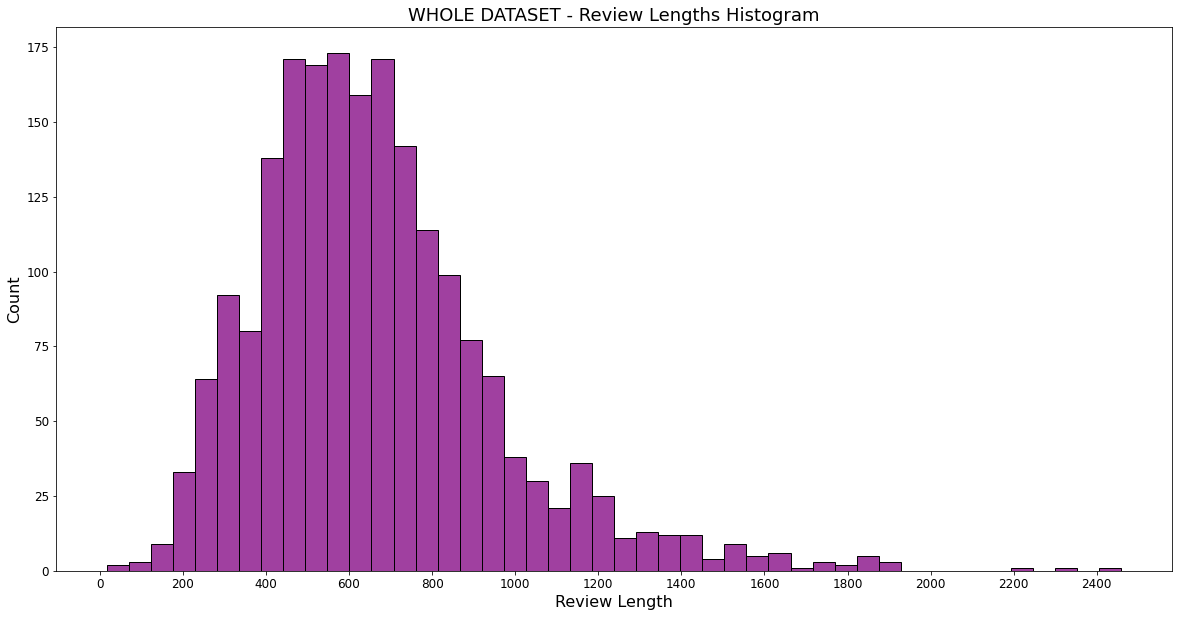

In [36]:
print("CONSIDERING ALL DATASET")
plt.figure(figsize=(20, 10))
end=max(review_lengths)
plt.xticks(np.arange(0,end,200.0), fontsize=12)
plt.yticks(fontsize=12)
sns.histplot(data=review_df, x="review_length",color="purple")
plt.title('WHOLE DATASET - Review Lengths Histogram', fontsize=18)
plt.xlabel('Review Length', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()



#### Histogram from review lengths (ONLY TRAIN DATA SET)

CONSIDERING TRAIN DATASET


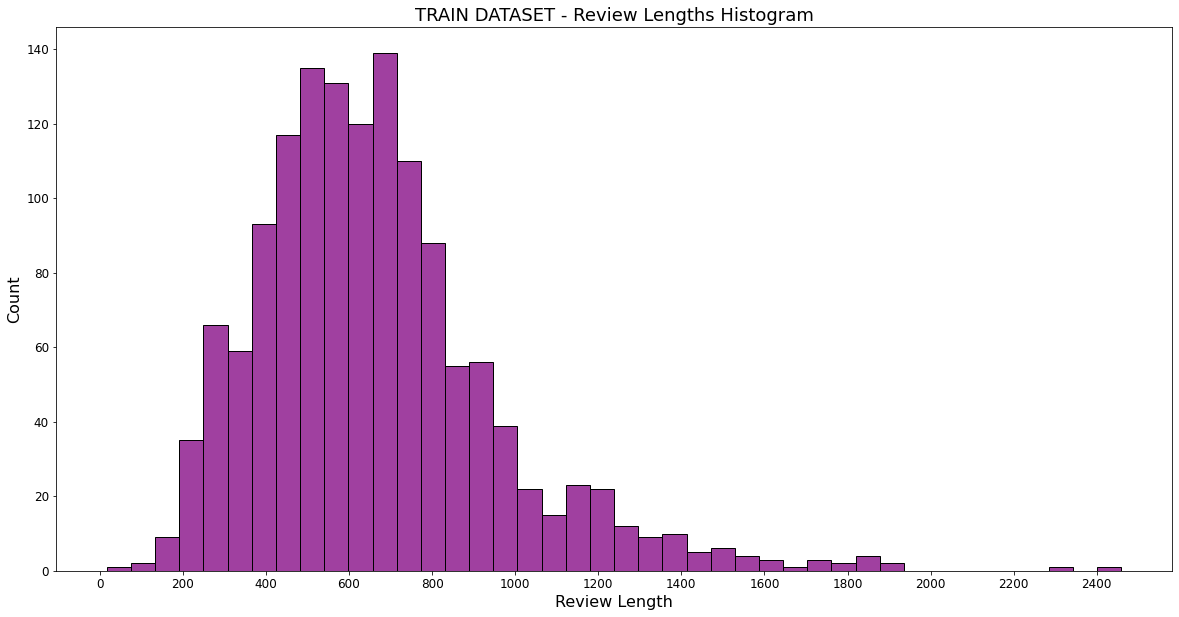

In [37]:
print("CONSIDERING TRAIN DATASET")
plt.figure(figsize=(20, 10))
end=max(tr_review_lengths)
plt.xticks(np.arange(0,end,200.0), fontsize=12)
plt.yticks(fontsize=12)
sns.histplot(data=tr_review_df, x="review_length",color="purple")
plt.title('TRAIN DATASET - Review Lengths Histogram', fontsize=18)
plt.xlabel('Review Length', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

## 1-b-vii Word Tokenization

#### For the rest of the questions, i.e. c,d,e,f i have used  tokenizer fitted on train data. Here for my own observations, I have shown  two tokenizers and their results - tokenizer fitted on whole data set and tokenizer fitted on train data set

### Tokenizer fitted on whole dataset

In [38]:
all_docs = raw_df_updated['contents']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_docs)
print("************************** TOKENIZED: FREQUENCY MAP ************************** ")
print(tokenizer.word_counts)


************************** TOKENIZED: FREQUENCY MAP ************************** 
OrderedDict([('films', 1536), ('adapted', 46), ('from', 4999), ('comic', 389), ('books', 78), ('have', 4902), ('had', 1546), ('plenty', 134), ('of', 34126), ('success', 216), ('whether', 217), ('they', 4826), ('re', 1134), ('about', 3524), ('superheroes', 12), ('batman', 203), ('superman', 26), ('spawn', 82), ('or', 3148), ('geared', 14), ('toward', 100), ('kids', 328), ('casper', 23), ('the', 76574), ('arthouse', 3), ('crowd', 80), ('ghost', 81), ('world', 1037), ('but', 8636), ('there', 3771), ('s', 18886), ('never', 1375), ('really', 1565), ('been', 2050), ('a', 38111), ('book', 347), ('like', 3691), ('hell', 240), ('before', 993), ('for', 9961), ('starters', 8), ('it', 16110), ('was', 4940), ('created', 167), ('by', 6262), ('alan', 101), ('moore', 84), ('and', 35581), ('eddie', 149), ('campbell', 94), ('who', 5692), ('brought', 157), ('medium', 31), ('to', 31939), ('whole', 496), ('new', 1292), ('level'

In [39]:
print("Document count is :",tokenizer.document_count)

Document count is : 2000


In [40]:
print("************************Ranking or Word Index of all the tokens************************\n")
print(tokenizer.word_index)


************************Ranking or Word Index of all the tokens************************

{'the': 1, 'a': 2, 'and': 3, 'of': 4, 'to': 5, 'is': 6, 'in': 7, 's': 8, 'it': 9, 'that': 10, 'as': 11, 'with': 12, 'for': 13, 'his': 14, 'this': 15, 'film': 16, 'i': 17, 'he': 18, 'but': 19, 'on': 20, 'are': 21, 't': 22, 'by': 23, 'be': 24, 'one': 25, 'movie': 26, 'an': 27, 'who': 28, 'not': 29, 'you': 30, 'from': 31, 'at': 32, 'was': 33, 'have': 34, 'they': 35, 'has': 36, 'her': 37, 'all': 38, 'there': 39, 'like': 40, 'so': 41, 'out': 42, 'about': 43, 'up': 44, 'more': 45, 'what': 46, 'when': 47, 'which': 48, 'or': 49, 'she': 50, 'their': 51, 'some': 52, 'just': 53, 'can': 54, 'if': 55, 'we': 56, 'him': 57, 'into': 58, 'even': 59, 'only': 60, 'than': 61, 'no': 62, 'good': 63, 'time': 64, 'most': 65, 'its': 66, 'will': 67, 'story': 68, 'would': 69, 'been': 70, 'much': 71, 'character': 72, 'also': 73, 'get': 74, 'other': 75, 'do': 76, 'two': 77, 'well': 78, 'them': 79, 'very': 80, 'characters': 81,

In [41]:
print("*********** Word to the number of documents/texts they appeared*****************\n\n")
print(tokenizer.word_docs)

*********** Word to the number of documents/texts they appeared*****************


defaultdict(<class 'int'>, {'strong': 224, 'captures': 35, 'geniuses': 8, 'indians': 10, 'steve': 113, 'her': 1116, 'ghastly': 9, 'ians': 1, 'holds': 80, 'graphic': 77, 'thoroughly': 68, 'hollow': 36, 'opened': 39, 'remind': 28, 'nearly': 264, 'guttenberg': 4, 'oscar': 183, 'dark': 214, 'make': 1017, 'world': 604, 'carving': 5, 'dreams': 98, 'great': 698, 'street': 117, 'geared': 14, 'though': 638, 'actually': 575, 'widower': 7, 'than': 1284, 'think': 589, 'creepy': 77, 'capable': 63, 'victorian': 6, 'researched': 1, 'white': 220, 'solid': 158, 'up': 1461, 'a': 1996, 'this': 1896, 'violent': 118, 'typically': 25, 'bleak': 46, 'crowd': 71, 'british': 103, 'original': 422, 'their': 1295, 'simpsons': 7, 'crack': 35, 'terry': 36, 'amounts': 33, 'robbie': 15, 'reasons': 119, 'time': 1258, 'find': 579, 'brothers': 120, 'finished': 34, 'go': 751, 'plenty': 113, 'directors': 96, 'until': 378, 'unfortunates': 2, 

In [42]:
encoded_docs = tokenizer.texts_to_matrix(all_docs, mode='count')
encoded_docs

array([[ 0., 46., 15., ...,  0.,  0.,  0.],
       [ 0., 35., 22., ...,  0.,  0.,  0.],
       [ 0., 33.,  9., ...,  0.,  0.,  0.],
       ...,
       [ 0., 35., 13., ...,  0.,  0.,  0.],
       [ 0., 16., 17., ...,  0.,  0.,  0.],
       [ 0., 36., 15., ...,  1.,  1.,  1.]])

In [43]:
print("Shape of encoded docs:", encoded_docs.shape)

Shape of encoded docs: (2000, 38912)


### Tokenizer fitted on train dataset


In [44]:
train_docs = train_data['contents']
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(train_docs)
print("************************** TOKENIZED: FREQUENCY MAP ************************** ")
print(tr_tokenizer.word_counts)


************************** TOKENIZED: FREQUENCY MAP ************************** 
OrderedDict([('films', 1072), ('adapted', 25), ('from', 3440), ('comic', 282), ('books', 59), ('have', 3385), ('had', 1076), ('plenty', 91), ('of', 23686), ('success', 154), ('whether', 149), ('they', 3330), ('re', 807), ('about', 2417), ('superheroes', 10), ('batman', 153), ('superman', 22), ('spawn', 80), ('or', 2153), ('geared', 13), ('toward', 68), ('kids', 228), ('casper', 12), ('the', 53271), ('arthouse', 2), ('crowd', 57), ('ghost', 64), ('world', 739), ('but', 6021), ('there', 2620), ('s', 13382), ('never', 933), ('really', 1110), ('been', 1439), ('a', 26664), ('book', 240), ('like', 2588), ('hell', 166), ('before', 680), ('for', 6884), ('starters', 4), ('it', 11363), ('was', 3460), ('created', 130), ('by', 4398), ('alan', 75), ('moore', 61), ('and', 24787), ('eddie', 114), ('campbell', 77), ('who', 3964), ('brought', 104), ('medium', 22), ('to', 22244), ('whole', 350), ('new', 900), ('level', 185),

In [45]:
print("Document count is :",tr_tokenizer.document_count)

Document count is : 1400


In [46]:
print("************************Ranking or Word Index of all the tokens************************\n")
print(tr_tokenizer.word_index)


************************Ranking or Word Index of all the tokens************************

{'the': 1, 'a': 2, 'and': 3, 'of': 4, 'to': 5, 'is': 6, 'in': 7, 's': 8, 'it': 9, 'that': 10, 'as': 11, 'with': 12, 'for': 13, 'his': 14, 'film': 15, 'this': 16, 'i': 17, 'he': 18, 'but': 19, 'on': 20, 'are': 21, 't': 22, 'by': 23, 'be': 24, 'one': 25, 'an': 26, 'who': 27, 'movie': 28, 'not': 29, 'you': 30, 'at': 31, 'was': 32, 'from': 33, 'have': 34, 'they': 35, 'has': 36, 'her': 37, 'all': 38, 'there': 39, 'like': 40, 'out': 41, 'so': 42, 'about': 43, 'more': 44, 'up': 45, 'what': 46, 'when': 47, 'which': 48, 'or': 49, 'she': 50, 'their': 51, 'some': 52, 'just': 53, 'can': 54, 'if': 55, 'we': 56, 'into': 57, 'him': 58, 'even': 59, 'no': 60, 'only': 61, 'than': 62, 'time': 63, 'good': 64, 'most': 65, 'its': 66, 'will': 67, 'story': 68, 'would': 69, 'been': 70, 'much': 71, 'character': 72, 'get': 73, 'also': 74, 'other': 75, 'do': 76, 'well': 77, 'first': 78, 'two': 79, 'very': 80, 'characters': 81

In [47]:
print("*********** Word to the number of documents/texts they appeared*****************\n\n")
print(tr_tokenizer.word_docs)

*********** Word to the number of documents/texts they appeared*****************


defaultdict(<class 'int'>, {'strong': 148, 'captures': 28, 'geniuses': 7, 'indians': 8, 'steve': 83, 'her': 789, 'ghastly': 4, 'ians': 1, 'holds': 59, 'graphic': 57, 'thoroughly': 48, 'hollow': 27, 'opened': 24, 'remind': 16, 'nearly': 186, 'guttenberg': 4, 'oscar': 130, 'dark': 159, 'make': 717, 'world': 429, 'carving': 3, 'dreams': 71, 'great': 480, 'street': 76, 'geared': 13, 'though': 435, 'actually': 417, 'widower': 5, 'than': 889, 'think': 416, 'creepy': 58, 'capable': 41, 'victorian': 5, 'researched': 1, 'white': 160, 'solid': 106, 'up': 1018, 'a': 1398, 'this': 1332, 'violent': 84, 'typically': 17, 'bleak': 32, 'crowd': 50, 'british': 67, 'original': 294, 'their': 888, 'simpsons': 5, 'crack': 25, 'terry': 24, 'amounts': 25, 'robbie': 12, 'reasons': 78, 'time': 886, 'find': 401, 'brothers': 79, 'finished': 26, 'go': 526, 'plenty': 80, 'directors': 72, 'until': 291, 'unfortunates': 2, 'whole': 271,

In [48]:
tr_encoded_docs = tr_tokenizer.texts_to_matrix(train_docs, mode='count')
tr_encoded_docs

array([[ 0., 46., 15., ...,  0.,  0.,  0.],
       [ 0., 35., 22., ...,  0.,  0.,  0.],
       [ 0., 33.,  9., ...,  0.,  0.,  0.],
       ...,
       [ 0., 42., 23., ...,  0.,  0.,  0.],
       [ 0., 28., 24., ...,  0.,  0.,  0.],
       [ 0., 23., 17., ...,  1.,  1.,  1.]])

In [49]:
print("Shape of encoded docs:", tr_encoded_docs.shape)

Shape of encoded docs: (1400, 33689)


### 1-b-viii Selecting review length L

I have found L based on the train data set and whole data set. 
Using L found on the train dataset, for the rest of the questions. As prof confirmed,Although Using L found with whole dataset doesn't contribute to information leak, I am using L found with train data. In real world , since we should not
touch test data, I feel using L with train data as more realistic.
Also as seen below, the L value is not that different, whether we consider whole data or just train data

#### Finding L w.r.t whole dataset

In [50]:
L = review_df.review_length.quantile(0.70)
print("Review length such that 70% of the reviews have a length below it: ", L)

Review length such that 70% of the reviews have a length below it:  759.3


In [51]:
### VERIFICATION
count=0;
for r in review_lengths:
    if(r<=L):
        count=count+1;
count
print("Percentage of reviews under L:", (count/2000)*100)

Percentage of reviews under L: 70.0


#### Finding L w.r.t train dataset

In [52]:
L_tr = tr_review_df.review_length.quantile(0.70)
print("Review length such that 70% of the reviews have a length below it: ", L_tr)

Review length such that 70% of the reviews have a length below it:  753.3


In [53]:
### VERIFICATION
count=0;
for r in tr_review_lengths:
    if(r<=L_tr):
        count=count+1;
count
print("Percentage of reviews under L:", (count/1400)*100)

Percentage of reviews under L: 70.0


### 1-b-ix Processing reviews - Truncate and Zero-pad

#### Using tokenizer fitted with Whole dataset

In [54]:
sequences = tokenizer.texts_to_sequences(all_docs)
L_int=int(L);
post_pad = pad_sequences(sequences, padding='post', maxlen=L_int, truncating='post')
print("Sequence shape:", post_pad.shape)
print("Whole dataset: After truncating and zero padding - \n")
print(post_pad)

Sequence shape: (2000, 759)
Whole dataset: After truncating and zero padding - 

[[  96 2793   31 ...    0    0    0]
 [ 150  144    3 ...    0    0    0]
 [  30  178  297 ...    0    0    0]
 ...
 [   1  422    7 ...    0    0    0]
 [  39   33    2 ...    0    0    0]
 [  77  782  518 ...    0    0    0]]


#### Using tokenizer fitted with train dataset

In [55]:
tr_sequences = tr_tokenizer.texts_to_sequences(train_docs)
te_sequences = tr_tokenizer.texts_to_sequences(test_data['contents'])
L_int=int(L_tr);
train_post_pad = pad_sequences(tr_sequences, padding='post', maxlen=L_int, truncating='post')
test_post_pad = pad_sequences(te_sequences, padding='post', maxlen=L_int, truncating='post')
print("Train Sequence shape:", train_post_pad.shape)
print("Train dataset: After truncating and zero padding - \n")
print(train_post_pad)
print("Test Sequence shape:", test_post_pad.shape)
print("Test dataset: After truncating and zero padding - \n")
print(test_post_pad)

Train Sequence shape: (1400, 753)
Train dataset: After truncating and zero padding - 

[[  97 3443   33 ...    0    0    0]
 [ 151  142    3 ...    0    0    0]
 [  30  173  295 ...    0    0    0]
 ...
 [4868  661   22 ...    0    0    0]
 [  77  123    8 ...    0    0    0]
 [1146   17   53 ...    0    0    0]]
Test Sequence shape: (600, 753)
Test dataset: After truncating and zero padding - 

[[ 336  102  464 ...    2  139  204]
 [ 153 9185   31 ...   53 1579   57]
 [   1   81    7 ...    0    0    0]
 ...
 [   1  426    7 ...    0    0    0]
 [  39   32    2 ...    0    0    0]
 [  79  878  501 ...    0    0    0]]


# 1-c-Word Embeddings

https://www.kaggle.com/code/rajmehra03/a-detailed-explanation-of-keras-embedding-layer/notebook <br>
https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce

#### Observations
Based on reading this article, (https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/ ) we should fit the tokenizer on train data, and generate sequences for train and test set. Word ranking is found for all the words in the tokenizer. We can use this tokenizer fitted on train data to generate the train data sequences and test data sequences. For the words in test data not identified by tokenizer, the value in the sequence for that word is 0.

Based on this link (https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948), tokenizer is fitted on the whole data, and sequences are generated. Afterwards, train and test sequences are splitted. In a realistic scenario, we may not have the access to the whole of test data. So it make sense to me, to fit the tokenizer on train data.

Also, I have used L found based on train data

Based on the tensorflow version you use, you may encounter this warning when run. This is a known bug in old tensor flow versions


WARNING:tensorflow:AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x1383189d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x1383189d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Train Data: Embeddings Shape: (1400, 24096)


### Preparing Train and test sequence: Using 5000 most common words

In [56]:
trainX=train_data['contents']
trainY=train_data['class']
testX=test_data['contents']
testY=test_data['class']

tk = Tokenizer(num_words=5001)
tk.fit_on_texts(trainX)

tk_train_sequences = tk.texts_to_sequences(trainX)
tk_test_sequences = tk.texts_to_sequences(testX)
L_int=int(L_tr);
trainX_padded_seq = pad_sequences(tk_train_sequences, padding='post', maxlen=L_int, truncating='post')
testX_padded_seq=pad_sequences(tk_test_sequences, padding='post', maxlen=L_int, truncating='post')

print("Train X shape:",trainX_padded_seq .shape)
print("Test X shape:", testX_padded_seq.shape)


Train X shape: (1400, 753)
Test X shape: (600, 753)


In [57]:
print("Train Sequence: Top 5000 words - After truncating and zero padding - \n")
print(trainX_padded_seq)

Train Sequence: Top 5000 words - After truncating and zero padding - 

[[  97 3443   33 ...    0    0    0]
 [ 151  142    3 ...    0    0    0]
 [  30  173  295 ...    0    0    0]
 ...
 [4868  661   22 ...    0    0    0]
 [  77  123    8 ...    0    0    0]
 [1146   17   53 ...    0    0    0]]


In [58]:
print("Test Sequence: Top 5000 words - After truncating and zero padding - \n")
print(testX_padded_seq)

Test Sequence: Top 5000 words - After truncating and zero padding - 

[[ 336  102  464 ...    9  176   22]
 [ 153   31 2364 ...    2   72  783]
 [   1   81    7 ...    0    0    0]
 ...
 [   1  426    7 ...    0    0    0]
 [  39   32    2 ...    0    0    0]
 [  79  878  501 ...    0    0    0]]


### Working with keras embedding layer

In [59]:
word_input=Input(shape=(L_int,),dtype='float64')  
word_embedding_layer=Embedding(input_dim=5001,output_dim=32,input_length=L_int)(word_input)
# combining all into a Keras model
embedded_model =Model([word_input],word_embedding_layer)
embedded_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
print(type(word_embedding_layer))
print(word_embedding_layer)

##Another method to create a model
# model = keras.Sequential()
##word_embedding_layer=Embedding(input_dim=5001,output_dim=32,input_length=L_int)
# model.add(word_embedding_layer)
# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
KerasTensor(type_spec=TensorSpec(shape=(None, 753, 32), dtype=tf.float32, name=None), name='embedding/embedding_lookup/Identity_1:0', description="created by layer 'embedding'")


In [60]:
embedded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 753)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 753, 32)           160032    
Total params: 160,032
Trainable params: 160,032
Non-trainable params: 0
_________________________________________________________________


In [100]:
output_embeddings=embedded_model.predict(trainX_padded_seq)
print("Embeddings Shape:", output_embeddings.shape)
print("\n************************Train data Embeddings***********************\n")
print(output_embeddings)

Embeddings Shape: (1400, 753, 32)

************************Train data Embeddings***********************

[[[-0.03895906 -0.03677431 -0.02564757 ... -0.03205853  0.04296688
   -0.0205513 ]
  [-0.0031243  -0.00945467 -0.01223444 ... -0.00225128  0.04129417
   -0.03292821]
  [ 0.0105155  -0.03427383  0.03577134 ...  0.02116226  0.01763796
   -0.02591262]
  ...
  [-0.01422656  0.00165266  0.03072098 ... -0.01976409  0.04602421
   -0.03198344]
  [-0.01422656  0.00165266  0.03072098 ... -0.01976409  0.04602421
   -0.03198344]
  [-0.01422656  0.00165266  0.03072098 ... -0.01976409  0.04602421
   -0.03198344]]

 [[ 0.02686609 -0.02509516  0.00611418 ...  0.04482109  0.03736335
   -0.04748687]
  [ 0.04634902 -0.0435317  -0.00978078 ...  0.04016359  0.03735001
    0.02081472]
  [ 0.04464579 -0.03311814 -0.04213197 ... -0.02218428 -0.0095396
    0.03752651]
  ...
  [-0.01422656  0.00165266  0.03072098 ... -0.01976409  0.04602421
   -0.03198344]
  [-0.01422656  0.00165266  0.03072098 ... -0.019764

In [62]:
test_output_embeddings=embedded_model.predict(testX_padded_seq)
print("Embeddings Shape:", test_output_embeddings.shape)
print("\n************************Predictions - Test data Embeddings***********************\n")
print(test_output_embeddings)

Embeddings Shape: (600, 753, 32)

************************Predictions - Test data Embeddings***********************

[[[ 0.00389063  0.00104369  0.02576489 ... -0.04495054 -0.03534399
    0.01912719]
  [ 0.00514239  0.03581293 -0.0490968  ... -0.02036146 -0.04955163
   -0.00323009]
  [-0.02540724 -0.0415803  -0.00085371 ...  0.03526399  0.00676479
   -0.02994572]
  ...
  [-0.03621465  0.04601711 -0.02938837 ...  0.0284895   0.04334464
   -0.005593  ]
  [ 0.03159476 -0.01222626  0.00712153 ... -0.02746266  0.00371407
   -0.01271331]
  [ 0.04564074  0.00029529  0.04737821 ... -0.00704336 -0.03334825
   -0.03196067]]

 [[-0.03124191 -0.02984541 -0.02348118 ... -0.03274391 -0.00023406
    0.02696656]
  [-0.03141605 -0.00092044 -0.00879315 ...  0.00483485 -0.03027778
   -0.0167326 ]
  [ 0.00027354  0.00244584 -0.031271   ...  0.04039326 -0.03210182
   -0.02395965]
  ...
  [-0.02813429 -0.01505918  0.01928898 ... -0.00345992 -0.00736671
   -0.0488982 ]
  [-0.00575951  0.01159488 -0.04051664 

### 1.c. ii - Reshaping the embeddings - Flatten the matrix of each document to a vector

In [63]:
tr_embeddings_res=output_embeddings.reshape(output_embeddings.shape[0],output_embeddings.shape[1]*output_embeddings.shape[2])
print("Train data Embeddings shape:", tr_embeddings_res.shape)
tr_embeddings_res

Train data Embeddings shape: (1400, 24096)


array([[-0.03895906, -0.03677431, -0.02564757, ..., -0.01976409,
         0.04602421, -0.03198344],
       [ 0.02686609, -0.02509516,  0.00611418, ..., -0.01976409,
         0.04602421, -0.03198344],
       [ 0.04941529, -0.02934829,  0.03790717, ..., -0.01976409,
         0.04602421, -0.03198344],
       ...,
       [ 0.00899037, -0.00447721, -0.02623619, ..., -0.01976409,
         0.04602421, -0.03198344],
       [-0.03743529, -0.04143932, -0.01384329, ..., -0.01976409,
         0.04602421, -0.03198344],
       [-0.00507076, -0.02414825,  0.04246179, ..., -0.01976409,
         0.04602421, -0.03198344]], dtype=float32)

In [64]:
te_embeddings_res=test_output_embeddings.reshape(test_output_embeddings.shape[0],test_output_embeddings.shape[1]*test_output_embeddings.shape[2])
print("Test data Embeddings shape:", te_embeddings_res.shape)
te_embeddings_res

Test data Embeddings shape: (600, 24096)


array([[ 0.00389063,  0.00104369,  0.02576489, ..., -0.00704336,
        -0.03334825, -0.03196067],
       [-0.03124191, -0.02984541, -0.02348118, ..., -0.04395134,
        -0.00183302, -0.03314732],
       [-0.01153686, -0.04295654,  0.01177037, ..., -0.01976409,
         0.04602421, -0.03198344],
       ...,
       [-0.01153686, -0.04295654,  0.01177037, ..., -0.01976409,
         0.04602421, -0.03198344],
       [ 0.0427359 ,  0.04749444, -0.04572964, ..., -0.01976409,
         0.04602421, -0.03198344],
       [-0.04903448, -0.01323136,  0.02701918, ..., -0.01976409,
         0.04602421, -0.03198344]], dtype=float32)

### Printing the embeddings as a dataframe to be able to see all values

In [65]:
tr_embeddings_df= pd.DataFrame(tr_embeddings_res)
print("******************TRAIN DATA EMBEDDINGS**********************")
print(tr_embeddings_df)

******************TRAIN DATA EMBEDDINGS**********************
         0         1         2         3         4         5         6      \
0    -0.038959 -0.036774 -0.025648  0.022177 -0.017256  0.020728 -0.041573   
1     0.026866 -0.025095  0.006114 -0.032828  0.029413  0.032839  0.021047   
2     0.049415 -0.029348  0.037907  0.040021  0.023613  0.011604  0.014165   
3     0.032186  0.015551  0.044037  0.001729 -0.024452  0.038355 -0.016467   
4    -0.009774  0.047565  0.013427 -0.004804 -0.009145  0.019996 -0.048779   
...        ...       ...       ...       ...       ...       ...       ...   
1395 -0.022511  0.005282  0.003946 -0.040506 -0.047416 -0.002420  0.046452   
1396 -0.040026  0.000182  0.044680 -0.043823  0.039043 -0.020601  0.033377   
1397  0.008990 -0.004477 -0.026236 -0.025986 -0.025207  0.023137  0.005459   
1398 -0.037435 -0.041439 -0.013843 -0.028772 -0.041452 -0.010895 -0.049934   
1399 -0.005071 -0.024148  0.042462  0.047209 -0.038562 -0.004899  0.029356   

 

In [66]:
te_embeddings_df= pd.DataFrame(te_embeddings_res)
print("******************TEST DATA EMBEDDINGS**********************")
print(te_embeddings_df)

******************TEST DATA EMBEDDINGS**********************
        0         1         2         3         4         5         6      \
0    0.003891  0.001044  0.025765  0.004741  0.018998  0.043314  0.032802   
1   -0.031242 -0.029845 -0.023481 -0.006655 -0.003771 -0.033151 -0.033959   
2   -0.011537 -0.042957  0.011770  0.015541 -0.043254 -0.012792  0.000019   
3    0.049415 -0.029348  0.037907  0.040021  0.023613  0.011604  0.014165   
4    0.027752  0.027627  0.029197 -0.018640  0.021073 -0.030896  0.047860   
..        ...       ...       ...       ...       ...       ...       ...   
595 -0.002039  0.018508  0.028033 -0.026246  0.049810 -0.000738  0.026561   
596 -0.015395  0.031753 -0.028868 -0.017786 -0.010211 -0.003650  0.009409   
597 -0.011537 -0.042957  0.011770  0.015541 -0.043254 -0.012792  0.000019   
598  0.042736  0.047494 -0.045730  0.022423 -0.029262 -0.049553  0.014356   
599 -0.049034 -0.013231  0.027019 -0.026105  0.045073 -0.037295  0.034997   

        7     

## Alternative Method: Creating a model with the  embedding layer and Flatten Layer (combining c-i and c-ii)

In [67]:
word_vec=Flatten()(word_embedding_layer) # flatten
embedded_model_with_flatten =Model([word_input],word_vec) # combining all into a Keras model
embedded_model_with_flatten .compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(embedded_model_with_flatten.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 753)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 753, 32)           160032    
_________________________________________________________________
flatten (Flatten)            (None, 24096)             0         
Total params: 160,032
Trainable params: 160,032
Non-trainable params: 0
_________________________________________________________________
None


In [90]:
output_embeddings_with_flatten=embedded_model_with_flatten.predict(trainX_padded_seq)
print("Train Data: Embeddings Shape:", output_embeddings_with_flatten.shape)
print("\n************************Embeddings - Flattened***********************\n")
print(output_embeddings_with_flatten)

Train Data: Embeddings Shape: (1400, 24096)

************************Embeddings - Flattened***********************

[[-0.03895906 -0.03677431 -0.02564757 ... -0.01976409  0.04602421
  -0.03198344]
 [ 0.02686609 -0.02509516  0.00611418 ... -0.01976409  0.04602421
  -0.03198344]
 [ 0.04941529 -0.02934829  0.03790717 ... -0.01976409  0.04602421
  -0.03198344]
 ...
 [ 0.00899037 -0.00447721 -0.02623619 ... -0.01976409  0.04602421
  -0.03198344]
 [-0.03743529 -0.04143932 -0.01384329 ... -0.01976409  0.04602421
  -0.03198344]
 [-0.00507076 -0.02414825  0.04246179 ... -0.01976409  0.04602421
  -0.03198344]]


In [69]:
embeddings_reshaped=output_embeddings_with_flatten.reshape(-1,L_int,32)
print("Shape of embeddings : ",embeddings_reshaped.shape) 
print("****************NON FLATTENED- TRAIN EMBEDDINGS*******************")
print(embeddings_reshaped)

Shape of embeddings :  (1400, 753, 32)
****************NON FLATTENED- TRAIN EMBEDDINGS*******************
[[[-0.03895906 -0.03677431 -0.02564757 ... -0.03205853  0.04296688
   -0.0205513 ]
  [-0.0031243  -0.00945467 -0.01223444 ... -0.00225128  0.04129417
   -0.03292821]
  [ 0.0105155  -0.03427383  0.03577134 ...  0.02116226  0.01763796
   -0.02591262]
  ...
  [-0.01422656  0.00165266  0.03072098 ... -0.01976409  0.04602421
   -0.03198344]
  [-0.01422656  0.00165266  0.03072098 ... -0.01976409  0.04602421
   -0.03198344]
  [-0.01422656  0.00165266  0.03072098 ... -0.01976409  0.04602421
   -0.03198344]]

 [[ 0.02686609 -0.02509516  0.00611418 ...  0.04482109  0.03736335
   -0.04748687]
  [ 0.04634902 -0.0435317  -0.00978078 ...  0.04016359  0.03735001
    0.02081472]
  [ 0.04464579 -0.03311814 -0.04213197 ... -0.02218428 -0.0095396
    0.03752651]
  ...
  [-0.01422656  0.00165266  0.03072098 ... -0.01976409  0.04602421
   -0.03198344]
  [-0.01422656  0.00165266  0.03072098 ... -0.01976

In [70]:
te_output_embeddings_with_flatten=embedded_model_with_flatten.predict(testX_padded_seq)
print("Test Data: Embeddings Shape:", te_output_embeddings_with_flatten.shape)
print("\n************************ Test Embeddings - Flattened***********************\n")
print(te_output_embeddings_with_flatten)

Test Data: Embeddings Shape: (600, 24096)

************************ Test Embeddings - Flattened***********************

[[ 0.00389063  0.00104369  0.02576489 ... -0.00704336 -0.03334825
  -0.03196067]
 [-0.03124191 -0.02984541 -0.02348118 ... -0.04395134 -0.00183302
  -0.03314732]
 [-0.01153686 -0.04295654  0.01177037 ... -0.01976409  0.04602421
  -0.03198344]
 ...
 [-0.01153686 -0.04295654  0.01177037 ... -0.01976409  0.04602421
  -0.03198344]
 [ 0.0427359   0.04749444 -0.04572964 ... -0.01976409  0.04602421
  -0.03198344]
 [-0.04903448 -0.01323136  0.02701918 ... -0.01976409  0.04602421
  -0.03198344]]


In [71]:
te_embeddings_reshaped=te_output_embeddings_with_flatten.reshape(-1,L_int,32)
print("Shape of embeddings : ",te_embeddings_reshaped.shape) 
print("****************NON FLATTENED- TEST EMBEDDINGS*******************")
print(te_embeddings_reshaped)

Shape of embeddings :  (600, 753, 32)
****************NON FLATTENED- TEST EMBEDDINGS*******************
[[[ 0.00389063  0.00104369  0.02576489 ... -0.04495054 -0.03534399
    0.01912719]
  [ 0.00514239  0.03581293 -0.0490968  ... -0.02036146 -0.04955163
   -0.00323009]
  [-0.02540724 -0.0415803  -0.00085371 ...  0.03526399  0.00676479
   -0.02994572]
  ...
  [-0.03621465  0.04601711 -0.02938837 ...  0.0284895   0.04334464
   -0.005593  ]
  [ 0.03159476 -0.01222626  0.00712153 ... -0.02746266  0.00371407
   -0.01271331]
  [ 0.04564074  0.00029529  0.04737821 ... -0.00704336 -0.03334825
   -0.03196067]]

 [[-0.03124191 -0.02984541 -0.02348118 ... -0.03274391 -0.00023406
    0.02696656]
  [-0.03141605 -0.00092044 -0.00879315 ...  0.00483485 -0.03027778
   -0.0167326 ]
  [ 0.00027354  0.00244584 -0.031271   ...  0.04039326 -0.03210182
   -0.02395965]
  ...
  [-0.02813429 -0.01505918  0.01928898 ... -0.00345992 -0.00736671
   -0.0488982 ]
  [-0.00575951  0.01159488 -0.04051664 ...  0.049394

#### References

https://www.kaggle.com/code/rajmehra03/a-detailed-explanation-of-keras-embedding-layer/notebook

## d - Multi Layer Perceptron

### 1-d-i- Training Multi Layer Perceptron

https://programmathically.com/dropout-regularization-in-neural-networks-how-it-works-and-when-to-use-it/

### Setting up MLP network

In [79]:
model = Sequential(name='multi-layer-perceptron')
model.add(Embedding(5001,32, input_length=L_int))
model.add(Flatten())
model.add(Dense(50, activation="relu",name="denselayer1"))
model.add(Dropout(0.2))
model.add(Dense(50, activation="relu", name="denselayer2"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu",name="denselayer3"))
#  kernel_regularizer=regularizers.l2(0.001)
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid", name="sigmoid"))
# Compile the model, specifying a loss function, optimizer, and metrics
learning_rate=0.0012
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate),metrics=['accuracy']);
model.summary()


Model: "multi-layer-perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 753, 32)           160032    
_________________________________________________________________
flatten_3 (Flatten)          (None, 24096)             0         
_________________________________________________________________
denselayer1 (Dense)          (None, 50)                1204850   
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
denselayer2 (Dense)          (None, 50)                2550      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
denselayer3 (Dense)          (None, 50)     

### 1-d-ii Reporting train and test accuracy

https://stackoverflow.com/questions/61122276/keras-not-training-on-entire-dataset

In [81]:
tensorflow.get_logger().setLevel('INFO')
trainY_new=trainY.copy()
trainY_new = trainY_new.replace(-1,0)
testY_new=testY.copy()
testY_new = testY_new.replace(-1,0)
model.fit(trainX_padded_seq, trainY_new, batch_size=10, epochs=2, verbose=1)
te_scores=model.evaluate(testX_padded_seq, testY_new, verbose=1)

tr_scores=model.evaluate(trainX_padded_seq, trainY_new, verbose=1)

print("\nTest Accuracy: ", te_scores[1])
print("Train Accuracy: ", tr_scores[1])

Epoch 1/2
140/140 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.7900
Epoch 2/2
44/44 [==============================] - 0s 2ms/step - loss: 0.0364 - accuracy: 0.9864

Test Accuracy:  0.7400000095367432
Train Accuracy:  0.9864285588264465


## 1-e-One-Dimensional Convolutional Neural Network

In [82]:
cnn_model = Sequential(name='cnn')
cnn_model.add(Embedding(5001,32, input_length=L_int))
cnn_model.add(Conv1D(filters=32,kernel_size=3))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation="relu",name="denselayer1"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(50, activation="relu", name="denselayer2"))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(50, activation="relu",name="denselayer3"))
#  kernel_regularizer=regularizers.l2(0.001)
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation="sigmoid", name="sigmoid"))
# learning_rate=0.01
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
cnn_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy']);
cnn_model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 753, 32)           160032    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 751, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 375, 32)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12000)             0         
_________________________________________________________________
denselayer1 (Dense)          (None, 50)                600050    
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
denselayer2 (Dense)          (None, 50)                2550    

### 1-e-ii Reporting train and test accuracies of the model

In [85]:
cnn_model.fit(trainX_padded_seq, trainY_new, batch_size=10, epochs=2, verbose=1)
cnn_te_scores=cnn_model.evaluate(testX_padded_seq, testY_new, verbose=1)
cnn_tr_scores=cnn_model.evaluate(trainX_padded_seq, trainY_new, verbose=1)
print("\nTest Accuracy: ", cnn_te_scores[1])
print("Train Accuracy: ", cnn_tr_scores[1])

Epoch 1/2
140/140 [==============================] - 1s 4ms/step - loss: 0.5210 - accuracy: 0.9186
Epoch 2/2
44/44 [==============================] - 0s 3ms/step - loss: 0.1070 - accuracy: 0.9871

Test Accuracy:  0.8066666722297668
Train Accuracy:  0.9871428608894348


## 1-f-Long Short-Term Memory Recurrent Neural Network

Dropout mentioned in LSTM work as recurrent drop out

In [86]:
lstm_model = Sequential(name='LSTM')
L_int=int(L_tr)
lstm_model.add(Embedding(5001,32, input_length=L_int))
lstm_model.add(LSTM(units=32, dropout=0.2))
# lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(256, activation="relu",name="denselayer1"))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation="sigmoid", name="sigmoid"))
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.001),metrics=['accuracy']);
lstm_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 753, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
denselayer1 (Dense)          (None, 256)               8448      
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
sigmoid (Dense)              (None, 1)                 257       
Total params: 177,057
Trainable params: 177,057
Non-trainable params: 0
_________________________________________________________________


### 1-f-ii Reporting train and test accuracies of the model

### Running LSTM for a series of Epochs

In [87]:
##https://stackoverflow.com/questions/65813263/how-to-suppress-warningtensorflowautograph-could-not-transform-bound-method
##  a warning caused by tensorflow incompatibility bug
##WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2e02d04c0> and will run it as-is.
##Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.

##This is a known warning in tensorflow, and solved in later versions
##https://discuss.tensorflow.org/t/tensorflow-io-issue/7504

In [91]:
test_accuracy=[]
train_accuracy=[]
for epoch in range(10,51,5):
    print("In epoch iteration: ", epoch)
    lstm_model.fit(trainX_padded_seq, trainY_new, batch_size=10, epochs=epoch, verbose=1)
    lstm_te_scores=lstm_model.evaluate(testX_padded_seq, testY_new, verbose=1)
    
    lstm_tr_scores=lstm_model.evaluate(trainX_padded_seq, trainY_new, verbose=1)
    
    test_accuracy.append(lstm_te_scores[1])
    train_accuracy.append(lstm_tr_scores[1])

In epoch iteration:  10
Epoch 1/10
140/140 [==============================] - 50s 355ms/step - loss: 0.6863 - accuracy: 0.5479
Epoch 2/10
140/140 [==============================] - 50s 356ms/step - loss: 0.6563 - accuracy: 0.5829
Epoch 3/10
140/140 [==============================] - 50s 356ms/step - loss: 0.6087 - accuracy: 0.6236
Epoch 4/10
140/140 [==============================] - 49s 353ms/step - loss: 0.5602 - accuracy: 0.6271
Epoch 5/10
140/140 [==============================] - 50s 356ms/step - loss: 0.6312 - accuracy: 0.6186
Epoch 6/10
140/140 [==============================] - 128s 922ms/step - loss: 0.5448 - accuracy: 0.6350
Epoch 7/10
140/140 [==============================] - 52s 370ms/step - loss: 0.5388 - accuracy: 0.6436
Epoch 8/10
140/140 [==============================] - 50s 359ms/step - loss: 0.5393 - accuracy: 0.6350
Epoch 9/10
140/140 [==============================] - 51s 368ms/step - loss: 0.6282 - accuracy: 0.6550
Epoch 10/10
140/140 [===========================

140/140 [==============================] - 50s 360ms/step - loss: 0.3638 - accuracy: 0.8064
Epoch 21/25
140/140 [==============================] - 50s 360ms/step - loss: 0.3197 - accuracy: 0.8529
Epoch 22/25
140/140 [==============================] - 50s 360ms/step - loss: 0.3128 - accuracy: 0.8664
Epoch 23/25
140/140 [==============================] - 50s 360ms/step - loss: 0.3030 - accuracy: 0.8879
Epoch 24/25
140/140 [==============================] - 50s 360ms/step - loss: 0.2897 - accuracy: 0.8914
Epoch 25/25
44/44 [==============================] - 3s 70ms/step - loss: 0.2121 - accuracy: 0.9257
In epoch iteration:  30
Epoch 1/30
140/140 [==============================] - 50s 360ms/step - loss: 0.2854 - accuracy: 0.8729
Epoch 2/30
140/140 [==============================] - 50s 360ms/step - loss: 0.2199 - accuracy: 0.9236
Epoch 3/30
140/140 [==============================] - 50s 360ms/step - loss: 0.2035 - accuracy: 0.9350
Epoch 4/30
140/140 [==============================] - 51s 3

140/140 [==============================] - 51s 361ms/step - loss: 6.1165e-05 - accuracy: 1.0000
Epoch 3/40
140/140 [==============================] - 51s 362ms/step - loss: 4.3735e-05 - accuracy: 1.0000
Epoch 4/40
140/140 [==============================] - 51s 362ms/step - loss: 3.9775e-05 - accuracy: 1.0000
Epoch 5/40
140/140 [==============================] - 51s 362ms/step - loss: 4.0376e-05 - accuracy: 1.0000
Epoch 6/40
140/140 [==============================] - 51s 361ms/step - loss: 3.9023e-05 - accuracy: 1.0000
Epoch 7/40
140/140 [==============================] - 51s 361ms/step - loss: 3.1869e-05 - accuracy: 1.0000
Epoch 8/40
140/140 [==============================] - 51s 362ms/step - loss: 2.4967e-05 - accuracy: 1.0000
Epoch 9/40
140/140 [==============================] - 50s 361ms/step - loss: 3.0452e-05 - accuracy: 1.0000
Epoch 10/40
140/140 [==============================] - 51s 361ms/step - loss: 2.5133e-05 - accuracy: 1.0000
Epoch 11/40
140/140 [==========================

140/140 [==============================] - 51s 361ms/step - loss: 1.0959e-07 - accuracy: 1.0000
Epoch 37/45
140/140 [==============================] - 50s 360ms/step - loss: 1.3496e-07 - accuracy: 1.0000
Epoch 38/45
140/140 [==============================] - 50s 360ms/step - loss: 8.3276e-08 - accuracy: 1.0000
Epoch 39/45
140/140 [==============================] - 51s 364ms/step - loss: 9.0769e-08 - accuracy: 1.0000
Epoch 40/45
140/140 [==============================] - 50s 359ms/step - loss: 6.8630e-08 - accuracy: 1.0000
Epoch 41/45
140/140 [==============================] - 50s 359ms/step - loss: 5.9690e-08 - accuracy: 1.0000
Epoch 42/45
140/140 [==============================] - 50s 358ms/step - loss: 6.6502e-08 - accuracy: 1.0000
Epoch 43/45
140/140 [==============================] - 50s 359ms/step - loss: 6.5139e-08 - accuracy: 1.0000
Epoch 44/45
140/140 [==============================] - 50s 360ms/step - loss: 6.1733e-08 - accuracy: 1.0000
Epoch 45/45
44/44 [=====================

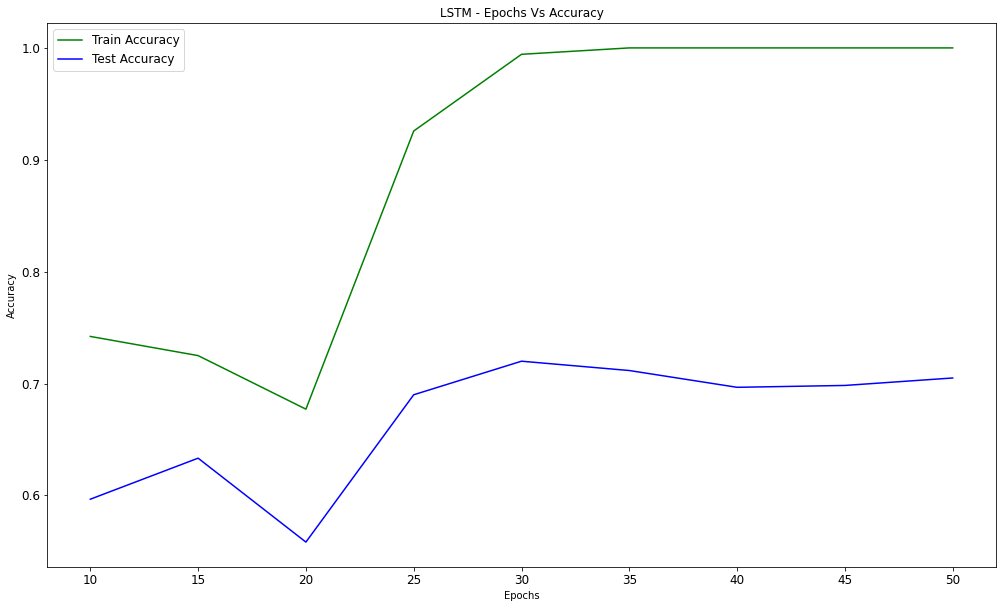

In [92]:
epochs=np.arange(10,51,5)
plt.figure(figsize=(17, 10))
plt.plot(epochs, train_accuracy, 'g', label="Train Accuracy")
plt.plot(epochs, test_accuracy, 'b', label="Test Accuracy")
plt.title('LSTM - Epochs Vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Train and test accuracies - LSTM Model

In [95]:
lstm_results={
    'Epoch': np.arange(10,51,5),
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy
};

lstm_df=pd.DataFrame(lstm_results);
lstm_df

Epoch  Train Accuracy  Test Accuracy
0     10        0.742143       0.596667
1     15        0.725000       0.633333
2     20        0.677143       0.558333
3     25        0.925714       0.690000
4     30        0.994286       0.720000
5     35        1.000000       0.711667
6     40        1.000000       0.696667
7     45        1.000000       0.698333
8     50        1.000000       0.705000

#### From the above graph, I see that when Epoch=30, the test accuracy is high. After epoch increases more than 30, there is a slight decrease in the test accuracy, although the train accuracy increases to 1. Epoch=30 seems to be a good value for this data, beyond 30, we see overfitting.

For epoch related logs, we can see it is 140/140, since we have 1400 data and 10 batches. so it is 1400/10=140 

###  Best Epoch: Results

In [97]:
print("************************Accuracies when Epoch=40************************")
print("TRAIN ACCURACY OF LSTM MODEL IS: ",train_accuracy[4])
print("TEST ACCURACY OF LSTM MODEL IS: ", test_accuracy[4])

************************Accuracies when Epoch=40************************
TRAIN ACCURACY OF LSTM MODEL IS:  0.9942857027053833
TEST ACCURACY OF LSTM MODEL IS:  0.7200000286102295


## OBSERVATIONS

In [99]:
details = {
    'Models': ["Multi Layer Perceptron", "1-D CNN", "LSTM"],
    'Train Accuracy' : [tr_scores[1],cnn_tr_scores[1],train_accuracy[4]],
    'Test Accuracy' : [te_scores[1],cnn_te_scores[1], test_accuracy[4]]
}

results_df=pd.DataFrame(details, columns = ['Models', 'Train Accuracy', 'Test Accuracy'])
results_df



Models  Train Accuracy  Test Accuracy
0  Multi Layer Perceptron        0.986429       0.740000
1                 1-D CNN        0.987143       0.806667
2                    LSTM        0.994286       0.720000

As seen above for this case, 1-D CNN has the best test score

### REFERENCES

https://towardsdatascience.com/nlp-preparing-text-for-deep-learning-model-using-tensorflow2-461428138657#:~:text=Padding%20at%20the%20beginning%20allows,careful%20consideration%20and%20business%20knowledge
    https://towardsdatascience.com/nlp-preparing-text-for-deep-learning-model-using-tensorflow2-461428138657#:~:text=Padding%20at%20the%20beginning%20allows,careful%20consideration%20and%20business%20knowledge
    https://towardsdatascience.com/word-embeddings-for-sentiment-analysis-65f42ea5d26e
    https://www.kaggle.com/code/rajmehra03/a-detailed-explanation-of-keras-embedding-layer/notebook
    https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
    https://www.kaggle.com/code/kambarakun/simple-multi-layer-perceptron-by-keras/script
    https://towardsdatascience.com/introduction-to-multilayer-neural-networks-with-tensorflows-keras-api-abf4f813959
    https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91
    https://keras.io/guides/sequential_model/
    